**Introduction**

This notebook is a project regarding IEEE-CIS Fraud Detection Competition along with the completion of Data Mining university coursework. The aim is to develop a machine learning model that can predict the likelihood of a fraudulent online transaction.

There are only two type of dataset files involved which are transaction and identity, and both are also separated into train and test files: 
- train_transaction
- train_identity
- test_transaction
- test_identity

A sample submission file is also provided in this package.

** Creator: Arinn Danish bin Abdullah


Agenda:

1. Import library dependencies
2. Data pre-processing
3. Feature extraction
4. Model building
5. Evaluation

** Random Forest Classifier will be used as the machine learning model in this project.

1. Import library dependencies

In [2]:
# import important libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
# reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# load train transaction data and reduce memory
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_transaction = reduce_mem_usage(train_transaction)

# load train identity data and reduce memory
train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
train_identity = reduce_mem_usage(train_identity)

# merge data
train_merge = pd.merge(train_transaction, train_identity, how='left')

# return items in object
len_train_merge = len(train_merge)

# remove unused variables
del train_transaction, train_identity

# view data shape
print(train_merge.shape)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
(590540, 434)


In [5]:
# load test transaction data and reduce memory
test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
test_transaction = reduce_mem_usage(test_transaction)

# load test identity data and reduce memory
test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
test_transaction = reduce_mem_usage(test_transaction)

# merge data
test_merge = pd.merge(test_transaction, test_identity, how='left')

# remove unused variables
del test_transaction, test_identity

# view data shape
print(test_merge.shape)

Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 472.59 Mb (0.0% reduction)
(506691, 433)


In [6]:
# reduce memory usage
train_merge = reduce_mem_usage(train_merge)
test_merge  = reduce_mem_usage(test_merge)

Mem. usage decreased to 650.48 Mb (0.0% reduction)
Mem. usage decreased to 565.37 Mb (10.4% reduction)


In [7]:
# create submission file
submission = pd.DataFrame({'TransactionID': test_merge.TransactionID})

# view data shape
print(submission.shape)

(506691, 1)


Explanation: 

**[2]** Only necessary libraries were brought in.

**[3]** The function was created due to huge sized data and it will then reduce memory usage for faster processing speed and consume less storage.

**[4][5]** There are 434 columns including the dependent variable as 'isFraud'. Next, there are 590540 samples in the training data and 141907 records in the test data. The transaction and identity data were merged and separated only into two categories, which are train and test data. Unused variables were erased due to efficient memory optimization.

2. Data pre-processing

In [8]:
# check duplicated data
train_merge.duplicated().sum()

0

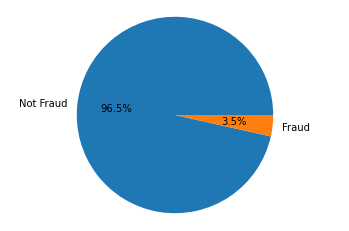

In [9]:
# check imbalance in data
plt.pie(train_merge.isFraud.value_counts(), labels=['Not Fraud', 'Fraud'],  autopct='%0.1f%%')
plt.axis('equal')
plt.show()

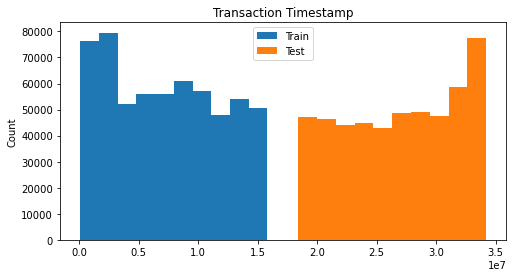

In [10]:
# view timestamp of train and test data
plt.figure(figsize=(8, 4))
plt.hist(train_merge['TransactionDT'], label='Train')
plt.hist(test_merge['TransactionDT'], label='Test')
plt.ylabel('Count')
plt.title('Transaction Timestamp')
plt.legend()
plt.show()

In [11]:
# check missing value
merged_dataframe = pd.concat([train_merge.drop(columns=['isFraud', 'TransactionID']), test_merge.drop(columns='TransactionID')])

# view data shape 
print(merged_dataframe.shape)

(1097231, 470)


In [12]:
# dependent variable
y = train_merge['isFraud']
print(y.shape)

(590540,)


In [13]:
# drop features (> 20% missing values)
missing_value = merged_dataframe.isnull().sum()/len(merged_dataframe)
merged_missing_value_dataframe = merged_dataframe.drop(columns=missing_value[missing_value>0.2].index)

# view data shape
print(merged_missing_value_dataframe.shape)

(1097231, 180)


In [14]:
# remove unused variables
del merged_dataframe, train_merge, test_merge

Explanation:

**[8]** No data duplication found

**[9]** There is a huge imbalance problem where "Not Fraud" dominates by 96.5% over "Fraud" data that only covered 3.5%. Hence, SMOTE, an oversampling technique will be used later to overcome this situation.

**[10]** The timestamp of test data is ahead of train data. Thus, time-based splitting is needed to create training and validation sets.

**[11][12][13]** High number of features that have missing value where only columns with 80% data will be used next  and the rest 20% containing high missing value to be filled. After removing features with more 20% missing values, only 180 columns remained out of originally 432. 

**[14]** Some unused variables are removed as well. 

3. Feature extraction

In [15]:
# filter numerical data
num_missing_value_dataframe = merged_missing_value_dataframe.select_dtypes(include=np.number)

# view data shape
print(num_missing_value_dataframe.shape)

(1097231, 176)


In [16]:
# filter categorical data
cat_missing_value_dataframe = merged_missing_value_dataframe.select_dtypes(exclude=np.number)

# view data shape
print(cat_missing_value_dataframe.shape)

(1097231, 4)


In [17]:
# remove unused variable
del merged_missing_value_dataframe

In [18]:
# fill missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_dataframe = pd.DataFrame(imp_median.fit_transform(num_missing_value_dataframe), columns=num_missing_value_dataframe.columns)

# view data shape
print(num_dataframe.shape)

(1097231, 176)


In [19]:
# remove unused variable
del num_missing_value_dataframe

In [20]:
# fill missing values by mode for categorical columns
imp_max = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_dataframe = pd.DataFrame(imp_max.fit_transform(cat_missing_value_dataframe), columns=cat_missing_value_dataframe.columns)

# view data shape
print(cat_dataframe.shape)

(1097231, 4)


In [21]:
# remove unused variable
del cat_missing_value_dataframe

In [22]:
# combine cleaned numerical and categorical data
merged_dataframe_cleaned = pd.concat([num_dataframe, cat_dataframe], axis=1)

# view data shape
print(merged_dataframe_cleaned.shape)

(1097231, 180)


In [23]:
# remove unused variable
del num_dataframe, cat_dataframe

In [24]:
# recheck missing values
print(f'Total missing values: {merged_dataframe_cleaned.isnull().sum().sum()}')

Total missing values: 0


In [25]:
# One-hot encoding
merged_dataframe_encoded = pd.get_dummies(merged_dataframe_cleaned, drop_first=True)

# view data shape
print(merged_dataframe_encoded.shape)

(1097231, 245)


In [26]:
# remove unused variable
del merged_dataframe_cleaned

Explanation:

**[15][16]** Data is filtered according to either it is numerical (eg. int, float, double etc.) or categorical (eg. char, string etc.)

**[18][20]** Since there are missing values for both numerical and categorical data, median will be used to fill in the numerical columns while for categorical columns, most frequent value or Mod will be used.

**[22]** After cleaning the data by separation and data-filling for both numerical and categorical columns, they were combined and other unused variables were removed.

**[24]** Missing value is now 0 after performing data-cleansing.

**[25]** One-hot encoding is to convert all data into numerical for machine learning model building purpose which will occur in the next step. Another xample of it is the binary classification where data only been classified as 0 or 1.

4. Model Building

In [27]:
# separate train and test data
X = merged_dataframe_encoded.iloc[:len_train_merge]
print(X.shape)
test_data = merged_dataframe_encoded.iloc[len_train_merge:]
print(test_data.shape)

(590540, 245)
(506691, 245)


In [28]:
# remove ununsed variable 
del merged_dataframe_encoded

In [29]:
# Time-based train validation splitting with 20% data in validation set
train = pd.concat([X, y], axis=1)
train.sort_values('TransactionDT', inplace=True)

X = train.drop(['isFraud'], axis=1)
y = train['isFraud']

split_index = int(0.8*len(X))
X_train = X.iloc[:split_index].values
X_val = X.iloc[split_index:].values
y_train = y.iloc[:split_index].values
y_val = y.iloc[split_index:].values

test_data = test_data.values

# view data shape
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(472432, 245) (118108, 245) (472432,) (118108,)


In [30]:
# remove unused variables
del y, train

In [31]:
# standardization 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

test_data_scaled = scaler.transform(test_data)

In [32]:
# class imbalance check
pd.value_counts(y_train)

# apply SMOTE to deal with the class imbalance by oversampling
# statistical technique for increasing number of cases in dataset in a balanced way
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# view data shape
print(X_train_smote.shape, y_train_smote.shape)

# recheck class imbalance
pd.value_counts(y_train_smote)

(911666, 245) (911666,)


0    455833
1    455833
dtype: int64

In [33]:
# remove unused variable
del X_train_scaled, y_train

In [34]:
# random forest classifier 
rfc = RandomForestClassifier(criterion='entropy', max_features='sqrt', max_samples=0.5, min_samples_split=80)
rfc.fit(X_train_smote, y_train_smote)
y_predproba = rfc.predict_proba(X_val_scaled)
print(f'Validation AUC={roc_auc_score(y_val, y_predproba[:, 1])}')

Validation AUC=0.8885553880882278


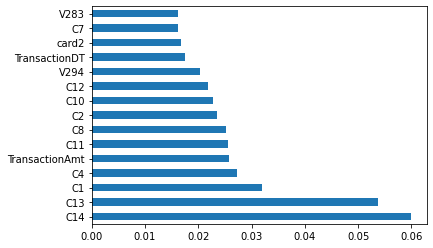

In [35]:
# feature importances
pd.Series(rfc.feature_importances_, index=X.columns).nlargest(15).plot(kind='barh')
plt.show()

Explanation:

**[27]** Training and testing data were separated in this stage where the number of columns divided are the same - 245, but differs in their observations.

**[29]** The data now is splited into 80% training set and 20& validation set where the training set is used to train and make the model learn the hidden features/patterns in the data. While in the validation set, it validates the model performance and gives information that helps us to tune the model’s hyperparameters and configurations accordingly. Test data were defined here as well to test the model perform after-completion.

**[32]** Standardization is a technique where it scales data to fit standard normal distribution, which valued from only 0 to 1. It is useful for optimization algorithms, such as gradient descent.

**[33]** SMOTE, which stands for Synthetic Minority Oversampling Technique, is a statistical technique for increasing the number of cases in your dataset in a balanced way. The component works by generating new instances from existing minority cases that you supply as input. Next, The class imbalance problem typically occurs when there are many more instances of some classes than others and it has been rechecked after the first attempt to ensure its success in balancing the instances.

**[35]** The reason why random forest algorithm is used in this project because it grows multiple decision trees which are merged together for a more accurate prediction. Other than it can handle large datasets efficiently, it also produces good predictions that can be understood easily. As an outcome, a validation AUC=0.89 was produced, which shows a good accuracy model.

**[36]** Take a look at feature importance indicates how much each feature contributes to the model prediction. In other words, it determines the degree of usefulness of a specific variable for a current model and prediction.

5. Evaluation

In [36]:
# predict test data 
predictions = rfc.predict_proba(test_data_scaled)
submission['isFraud'] = predictions[:, 1]
print(submission.shape)
submission.head()

(506691, 2)


,TransactionID,isFraud
0,3663549,0.048729
1,3663550,0.049421
2,3663551,0.196510
3,3663552,0.030799
4,3663553,0.162860


In [37]:
# submit predictions
submission.to_csv('mysubmission.csv', index=False)
print('You have submitted!')

You have submitted!


Explanation:

**[36]** The evaluation section describes formatting the "mysubmission" file and how the submission will be evaluated. Prediction here is a type of advanced analytics that uses statistical modeling and Data Mining techniques to make predictions about future outcomes. "IsFraud" displays probability of each transaction being fraudulent ranged from 0 -1. This happened after implementation of training the machine model into understanding the data, with good accuracy and next predict the best outcomes as shown in the data head above.

**[37]** Prediction is submitted to kaggle through creating a .csv file as an output